In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')



In [1]:
%load_ext rpy2.ipython

In [38]:
# Prepare
import pandas as pd
import os, requests, json, matplotlib_venn
import numpy as np
from matplotlib import pyplot as plt
os.chdir('/Users/denis/Documents/Projects/hiv-analysis/hiv-signature-analysis')
%R invisible(source('/Users/denis/Documents/Projects/scripts/Support.R'));
%R invisible(library(gplots));

# Initial Analysis of HIV Cell Line Dataset

## Overview

The purpose of this notebook is to perform basic analysis of the HIV data provided by Weijia Zhang.

The data is comprised of two datasets:
1. A dataset containing *13 samples* of **podocyte-derived cell lines**, divided in three batches.  3 samples are untreated, the rest are treated with HIV at different timepoints (6, 12, 24, 48h).
2. A dataset containing *21 samples* of **primary podocytes**, derived from 10 different patients.  The samples span three conditions: HIV-infected, GFP-infected controls, and untreated.

In [3]:
# Infiles
infiles = ['f2-normalized_expression_data.dir/primary_podocyte-vst.txt', 'f2-normalized_expression_data.dir/podocyte_cell_line-vst.txt', 'rawdata.dir/hiv_sample_annotation.txt']

# Get dataframes
primaryDataframe = pd.read_table(infiles[0]).set_index('gene_symbol').drop(['NK1', 'NK2'], axis=1)
derivedDataframe = pd.read_table(infiles[1]).set_index('gene_symbol')
annotationDataframe = pd.read_table(infiles[2]).set_index('sample_name').drop(['NK1', 'NK2'], axis=0)
derivedAnnotationDataframe = annotationDataframe[annotationDataframe['cell_type'] == 'cell_line'].drop(['patient','patient_group'], axis=1)
primaryAnnotationDataframe = annotationDataframe[annotationDataframe['cell_type'] == 'primary_podocyte'].drop(['timepoint','batch'], axis=1)

## 1. Exploratory Data Analysis

### 1.1 PCA Analysis

In [4]:
%%R
plotPCA <- function(expressionDataframe, sampleLabels, main='', legendTitle = '', PCs=c('PC1', 'PC2'))
{
    # Run PCA
    pcaRes <- runPCA(expressionDataframe)

    # Get plot matrix
    plotMatrix <- pcaRes$x

    # Get color legend
    sampleNames <- rownames(plotMatrix)
    colorLegend <- getLegend(sampleNames, sampleLabels)#, colors=c('black','red','blue'))

    # Plot
    plot(plotMatrix[,PCs],
         col=colorLegend$colors,
         xlab=pcaRes$varLabels[PCs[1]],
         ylab=pcaRes$varLabels[PCs[2]],
         main=main)

    # Legend
    legend('topright', legend=names(colorLegend$legend), fill=colorLegend$legend, title=legendTitle)
}

The PCA analysis aims at investigating the separation between samples across the datasets.  The samples are separated in 3 distinct clusters, largely determined by the batch.  The treatment status of the samples (HIV vs untreated) contributes to very little variance.

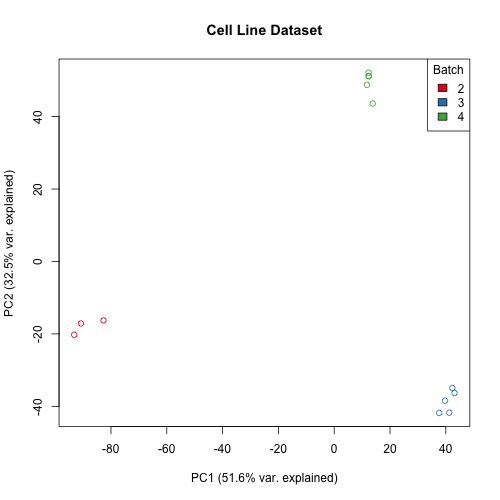

In [10]:
%%R -i derivedDataframe,primaryDataframe,derivedAnnotationDataframe,primaryAnnotationDataframe -h 500 -w 500

# Plot
plotPCA(derivedDataframe, derivedAnnotationDataframe[colnames(derivedDataframe), 'batch'], 'Cell Line Dataset', 'Batch')

### 1.2 Heatmap

The heatmap plots aim at investigating the separation between samples across the datasets.  As above, the samples in the cell-line dataset are separated in 3 distinct clusters, largely determined by the batch.

In [6]:
%%R
plotHeatmap <- function(expressionDataframe, sampleLabels, nGenes=1000, main='', pos=c(0, 0.7), legendTitle='Batch', method='complete')
{
    # Get gene variance
    geneVariance <- sort(apply(expressionDataframe, 1, var), decreasing=TRUE)

    # Get top genes
    topGenes <- names(geneVariance)[1:nGenes]

    # Get matrix
    plotMatrix <- as.matrix(expressionDataframe[topGenes,])

    # Get color legend
    sampleNames <- colnames(expressionDataframe)
    colorLegend <- getLegend(sampleNames, sampleLabels)

    # Plot margins
    par(mar=c(5,4,0,2))

    # Plot
    heatmap.2(plotMatrix,
              col=colorRampPalette(c('black','yellow','red')),
              trace='none',
              labRow = '',
              xlab = paste0(ncol(plotMatrix), ' samples'),
              ylab=paste0('Top ', nrow(plotMatrix), ' most variable genes'),
              mar=c(5,2),
              srtCol=45,
              key.title='Color Key',
              key.xlab='Expression level (VST)',
              ColSideColors=colorLegend$colors,
              hclustfun = function(x) hclust(x, method=method),
              main=main)

    # Add legend
    legend(pos[1], pos[2], legend=names(colorLegend$legend), fill=colorLegend$legend, title=legendTitle)
}

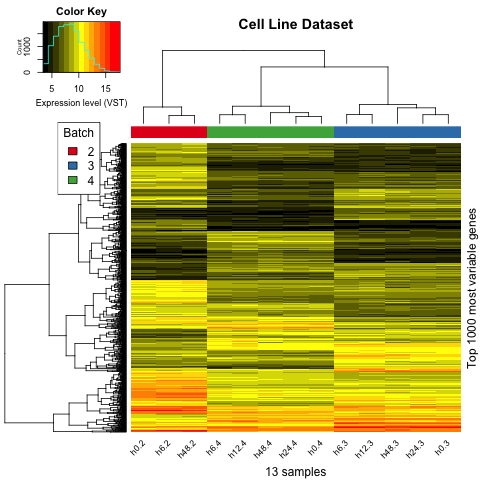

In [7]:
%%R
# Plot
plotHeatmap(derivedDataframe, derivedAnnotationDataframe[colnames(derivedDataframe), 'batch'], main='Cell Line Dataset')

## 2. Batch Effect Removal

In order to remove the batch effect on the RNA-seq samples, the batch effect removal algorith ComBat (Leek JT et al., 2016) was used.  The package is available on Bioconductor at the following URL: https://bioconductor.org/packages/release/bioc/html/sva.html.

### 2.1 ComBat Algorithm

A PCA analysis was performed comparing the original dataset to the processed dataset, in order to assess the effect of the batch removal algorithm.

In [11]:
# Infiles
infiles = ['f2-normalized_expression_data.dir/podocyte_cell_line-vst.txt', 'f3-adjusted_expression_data.dir/podocyte_cell_line-vst_corrected.txt']

# Read data
vstDataframe = pd.read_table(infiles[0]).set_index('gene_symbol')

# Read data
vstDataframeCorrected = pd.read_table(infiles[1]).set_index('gene_symbol')

# Create annotation dataframe
annotationDataframe = pd.DataFrame([[x, x.split('.')[0], x.split('.')[1]] for x in vstDataframe.columns], columns=['sample_id','timepoint','batch']).set_index('sample_id')

#### Batch Separation

The PCA analysis shows that samples are no longer clearly divided by batch effects after correction.

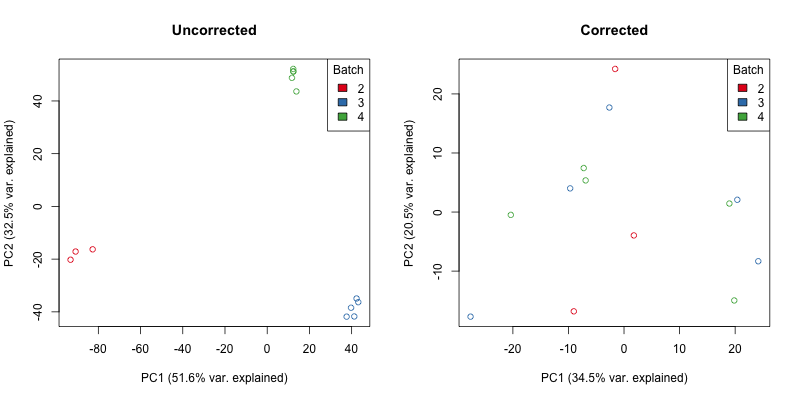

In [51]:
%%R -i vstDataframe,vstDataframeCorrected,annotationDataframe -h 400 -w 800
# Set grid
par(mfrow=c(1,2))

# Plot
plotPCA(vstDataframe, annotationDataframe[colnames(vstDataframe), 'batch'], 'Uncorrected', 'Batch')
plotPCA(vstDataframeCorrected, annotationDataframe[colnames(vstDataframe), 'batch'], 'Corrected', 'Batch')

#### Timepoint Separation

The PCA analysis shows that samples are somewhat separated by timepoint of infection.

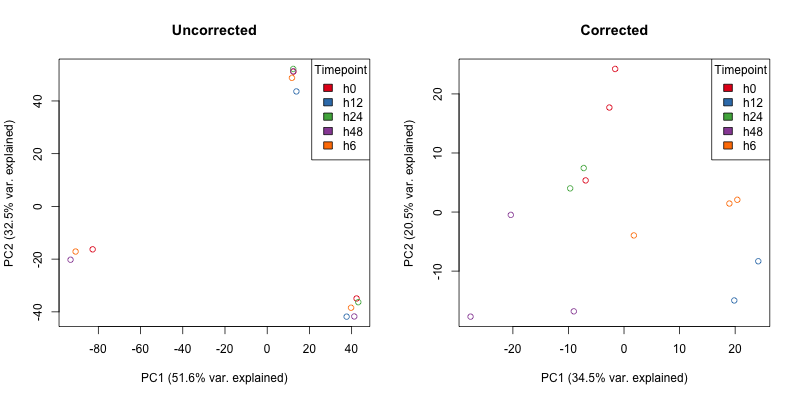

In [50]:
%%R -h 400 -w 800
# Set grid
par(mfrow=c(1,2))

# Plot
plotPCA(vstDataframe, annotationDataframe[colnames(vstDataframe), 'timepoint'], 'Uncorrected', 'Timepoint')
plotPCA(vstDataframeCorrected, annotationDataframe[colnames(vstDataframe), 'timepoint'], 'Corrected', 'Timepoint')

Heatmap analysis (as above) shows similar results.

In [20]:
# Define Enrichr API
def enrichr_get_url(genes, meta=''):
    """POST a gene list to Enrichr server and return the list ids"""
    genes_str = '\n'.join(genes)
    payload = {
        'list': (None, genes_str),
        'description': (None, meta)
    }
    # POST genes to the /addList endpoint
    response = requests.post("%s/addList" % 'http://amp.pharm.mssm.edu/Enrichr', files=payload)
    list_ids = json.loads(response.text)

    # Return URL
    result_url = 'http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=' + list_ids['shortId']
    return result_url

In [54]:
# Set number of genes
nGenes = 500

# Get variable genes
variableGeneDict = {}
variableGeneDict['uncorrected'] = vstDataframe.apply(np.var, 1).sort_values(ascending=False).index.tolist()[:nGenes]
variableGeneDict['corrected'] = vstDataframeCorrected.apply(np.var, 1).sort_values(ascending=False).index.tolist()[:nGenes]

In [56]:
# Get Enrichr links
enrichrLinkDict = {x:enrichr_get_url(variableGeneDict[x]) for x in variableGeneDict.keys()}

### 2.2 Enrichment analysis of top variable genes

In order to assess the effects of the batch effect removal from a biological standpoint, an enrichment analysis of the top 500 most variable genes was performed on the original dataset and the corrected dataset.  Links to the corresponding analysis results are displayed in the table below.

In [59]:
# Convert to dataframe
enrichrLinkDataframe = pd.DataFrame.from_dict(enrichrLinkDict, orient='index').rename(columns={0:'Enrichr Link'})

# Display
pd.options.display.max_colwidth = 100
enrichrLinkDataframe

,Enrichr Link
uncorrected,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18uxv
corrected,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18uxw


The top enriched terms include:
- *Uncorrected*: TP53 targets (FDR < 10<sup>-8</sup>), P53 pathway (FDR = 10<sup>-3</sup>), extracellular space (FDR < 10<sup>-7</sup>).
- *Corrected*: ESR targets (FDR < 10<sup>-6</sup>), Cytokine signaling in immune response (FDR < 10<sup>-6</sup>), extracellular space (FDR < 10<sup>-11</sup>).

## 3. Differential Expression Analysis

A Differential Expression Analysis using Characteristic Direction (CD) was performed in order to investigate the differential gene expression signatures generated by HIV treatment.  The same analysis was performed in the uncorrected and corrected datasets, to allow for comparison.

The analysis was performed on data normalized with the Variance Stabilizing Transformation (VST), available in the DESeq2 package (http://bioconductor.org/packages/release/bioc/html/DESeq2.html).  The resulting gene expression values are **not** in log-space, and variance between samples has comparable values.

In [30]:
# Get infiles
infiles = ['f4-differential_expression.dir/podocyte_cell_line-vst-differential_expression.txt', 'f4-differential_expression.dir/podocyte_cell_line-vst_corrected-differential_expression.txt']

# Read data
cdDataframe = pd.read_table(infiles[0]).rename(columns={'CD':'CD_uncorrected'})
correctedCdDataframe = pd.read_table(infiles[1]).rename(columns={'CD':'CD_corrected'})

# Merge dataframes
mergedCdDataframe = cdDataframe.merge(correctedCdDataframe, on='gene_symbol', how='inner').set_index('gene_symbol')

In [31]:
# Get number of genes
nGenes = 500

# Get top genes
upregulatedGenes = {x:set(mergedCdDataframe[x].sort_values(ascending=False).index[:nGenes]) for x in mergedCdDataframe.columns}
downregulatedGenes = {x:set(mergedCdDataframe[x].sort_values(ascending=True).index[:nGenes]) for x in mergedCdDataframe.columns}
combinedGenes = {x:set(abs(mergedCdDataframe[x]).sort_values(ascending=False).index[:nGenes]) for x in mergedCdDataframe.columns}   

### 3.1 Comparison of Uncorrected and Corrected Datasets

The following scatter plot displays the relationship between Characteristic Direction values of genes in the original dataset (X axis) and in the corrected dataset (Y axis).

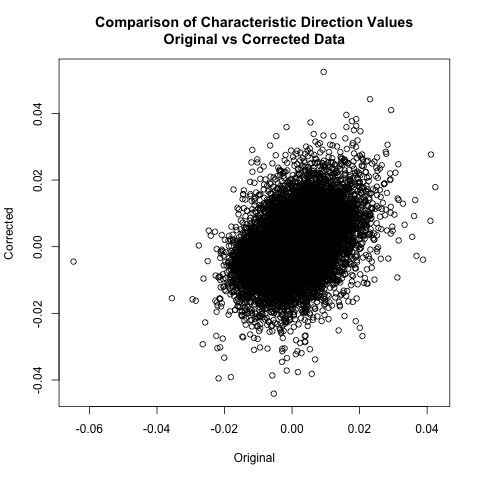

In [34]:
%%R -i mergedCdDataframe
plot(mergedCdDataframe,
     xlab = 'Original',
     ylab = 'Corrected',
     main = 'Comparison of Characteristic Direction Values\nOriginal vs Corrected Data')

### 3.2 Geneset Overlap

The following venn diagrams display the overlap of the differentially expressed genesets in the uncorrected vs corrected datasets.

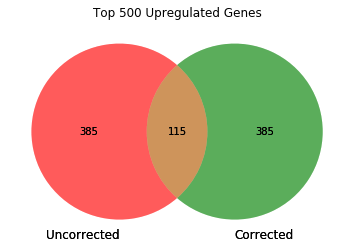

In [39]:
v = matplotlib_venn.venn2([upregulatedGenes['CD_uncorrected'], upregulatedGenes['CD_corrected']], set_labels=['Uncorrected','Corrected'])
plt.title('Top 500 Upregulated Genes')
plt.show()

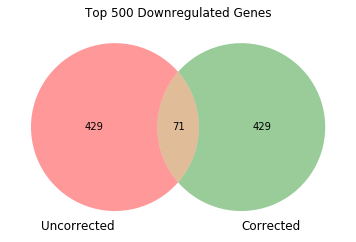

In [40]:
v = matplotlib_venn.venn2([downregulatedGenes['CD_uncorrected'], downregulatedGenes['CD_corrected']], set_labels=['Uncorrected','Corrected'])
plt.title('Top 500 Downregulated Genes')
plt.show()

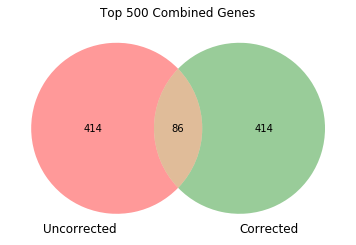

In [41]:
v = matplotlib_venn.venn2([combinedGenes['CD_uncorrected'], combinedGenes['CD_corrected']], set_labels=['Uncorrected','Corrected'])
plt.title('Top 500 Combined Genes')
plt.show()

In [42]:
# Define Enrichr API
def enrichr_get_url(genes, meta=''):
    """POST a gene list to Enrichr server and return the list ids"""
    genes_str = '\n'.join(genes)
    payload = {
        'list': (None, genes_str),
        'description': (None, meta)
    }
    # POST genes to the /addList endpoint
    response = requests.post("%s/addList" % 'http://amp.pharm.mssm.edu/Enrichr', files=payload)
    list_ids = json.loads(response.text)

    # Return URL
    result_url = 'http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=' + list_ids['shortId']
    return result_url

In [43]:
# Get geneset dict
genesetDict = {'Upregulated': upregulatedGenes, 'Downregulated': downregulatedGenes, 'Combined': combinedGenes}

# Get link dict
enrichrLinkDict = {dataset:{geneset:enrichr_get_url(genesetDict[dataset][geneset]) for geneset in genesetDict[dataset].keys()} for dataset in genesetDict.keys()}

### 3.3 Enrichment Analysis

In order to assess the enriched biological terms associated to the differentially expressed genesets, an Enrichr analysis was performed using the API.  Links to the Enrichr results to the corresponding datasets are available in the table below:

In [53]:
# Create dataframe
enrichrLinkDataframe = pd.DataFrame(enrichrLinkDict).T

# Display
pd.options.display.max_colwidth = 100
enrichrLinkDataframe

,CD_corrected,CD_uncorrected
Combined,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18us3,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18us5
Downregulated,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18us1,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18us2
Upregulated,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18urz,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18us0


In [47]:
def runL1000CDS2(differentialExpressionDataframe, column):
    # Set data
    data = {"genes": differentialExpressionDataframe.index.tolist(), "vals":differentialExpressionDataframe[column].tolist()}
    data['genes'] = [x.upper() for x in data['genes']]
    
    # Set configuration
    config = {"aggravate":False, "searchMethod":"CD", "share":True, "combination":True, "db-version":"latest"}
    payload = {"data":data,"config":config}
    headers = {'content-type':'application/json'}
    
    # Perform request
    r = requests.post('http://amp.pharm.mssm.edu/L1000CDS2/query',data=json.dumps(payload),headers=headers)
    resCD= r.json()
    
    # Return result
    resultUrl = 'http://amp.pharm.mssm.edu/L1000CDS2/#/result/' + resCD['shareId']
    return resultUrl

In [48]:
# Run analyses
l1000cds2Dict = {x: runL1000CDS2(mergedCdDataframe, x) for x in mergedCdDataframe.columns}

### 3.4 L1000CDS<sup>2</sup>

In order to identify small molecules which mimic or reverse the observed gene expression signatures associated to HIV treatment, a L1000CDS<sup>2</sup> analysis was performed on the signatures using the API.  Links to the L1000CDS<sup>2</sup> results are available in the table below:

In [61]:
# Convert to dataframe
l1000cds2Dataframe = pd.DataFrame.from_dict(l1000cds2Dict, orient='index').rename(columns={0:'L1000CDS2 Link'})

# Display
l1000cds2Dataframe

,L1000CDS2 Link
CD_corrected,http://amp.pharm.mssm.edu/L1000CDS2/#/result/589a43c5e467bea600fb5e8e
CD_uncorrected,http://amp.pharm.mssm.edu/L1000CDS2/#/result/589a43c0e467bea600fb5e8a
